# pm2.5 training notebook

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
from scipy import stats

## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## 特定一個 position 的 Linear Regression

暫定的做法是：將每一小時的資料做平均，然後將下一小時的 pm2.5 平均當作想要預測的 y。如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。拿來訓練的 columns 目前有 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity'。

### Load data


In [4]:
data3 = get_data_by_pos(0)

In [5]:
df3 = pd.DataFrame(data3)

In [6]:
df3.head()

,date,humidity,pm10,pm100,pm25,temp
0,2019-05-17 17:05:40+08:00,76,14,31,14,26
1,2019-05-17 17:20:39+08:00,69,10,13,13,28
2,2019-05-17 17:35:38+08:00,68,13,19,18,28
3,2019-05-17 17:50:37+08:00,67,10,14,14,28
4,2019-05-17 18:05:35+08:00,67,12,16,16,28


### Data preprocessing

In [7]:
# Input time
time = ['2019 05 11', '2019 08 06']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
# df3 = df3.loc[ df3['date'] >= start_time ]
# df3 = df3.loc[ df3['date'] <= end_time ]

In [8]:
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

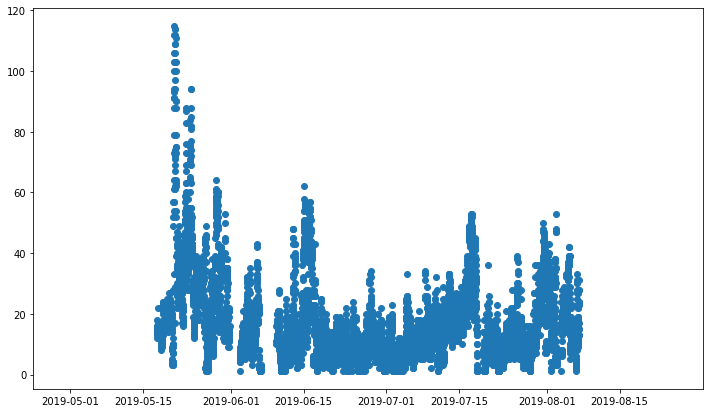

In [9]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df3['date'], df3['pm2.5'])

In [10]:
# Exclude outliers
# want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
# df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 7).all(axis=1)]
df3 = df3.loc[ df3['pm2.5'] < 120 ]

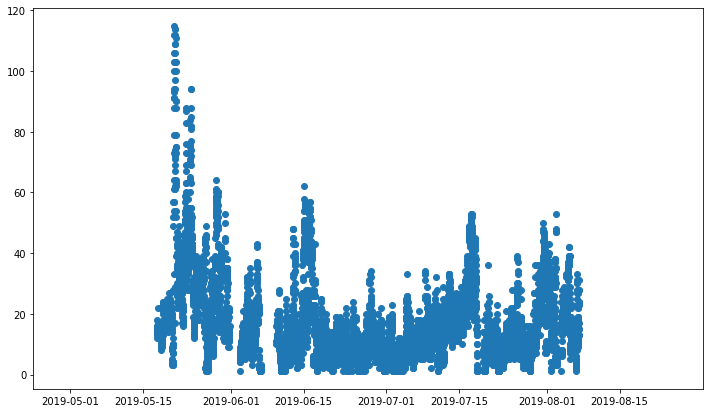

In [11]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df3['date'], df3['pm2.5'])

In [12]:
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)

In [13]:
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]

In [14]:
df3.head()

,month,day,weekday,hour,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,17,4,17,17.083333,14,14,31,26,76
1,5,17,4,17,17.333333,10,13,13,28,69
2,5,17,4,17,17.583333,13,18,19,28,68
3,5,17,4,17,17.833333,10,14,14,28,67
4,5,17,4,18,18.083333,12,16,16,28,67


In [15]:
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()

In [16]:
df3mean.head(10)

weekday  hour_minute  pm1.0  pm2.5  pm10.0  temp  humidity
month day hour                                                            
5     17  17        4.0    17.458333  11.75  14.75   19.25  27.5     70.00
          18        4.0    18.458333  11.25  15.50   15.50  28.0     68.00
          19        4.0    19.458333  10.50  13.75   14.00  27.0     69.75
          20        4.0    20.458333  10.50  13.50   13.75  27.0     69.00
          21        4.0    21.458333  11.00  14.25   14.25  27.0     69.25
          22        4.0    22.458333  11.50  15.00   15.25  27.0     71.00
          23        4.0    23.458333  11.00  15.25   15.50  27.0     72.50
      18  0         5.0     0.458333  12.00  16.75   16.75  26.0     75.25
          1         5.0     1.450000  12.25  15.25   15.25  26.0     75.50
          2         5.0     2.441667  11.50  16.00   17.00  26.0     79.00

In [17]:
df3mean.reset_index(inplace=True)

In [18]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,17,17,4.0,17.458333,11.75,14.75,19.25,27.5,70.00
1,5,17,18,4.0,18.458333,11.25,15.50,15.50,28.0,68.00
2,5,17,19,4.0,19.458333,10.50,13.75,14.00,27.0,69.75
3,5,17,20,4.0,20.458333,10.50,13.50,13.75,27.0,69.00
4,5,17,21,4.0,21.458333,11.00,14.25,14.25,27.0,69.25


In [19]:
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [20]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time
0,5,17,17,4.0,17.458333,11.75,14.75,19.25,27.5,70.00,2019-05-17 16:54:00+08:00
1,5,17,18,4.0,18.458333,11.25,15.50,15.50,28.0,68.00,2019-05-17 17:54:00+08:00
2,5,17,19,4.0,19.458333,10.50,13.75,14.00,27.0,69.75,2019-05-17 18:54:00+08:00
3,5,17,20,4.0,20.458333,10.50,13.50,13.75,27.0,69.00,2019-05-17 19:54:00+08:00
4,5,17,21,4.0,21.458333,11.00,14.25,14.25,27.0,69.25,2019-05-17 20:54:00+08:00


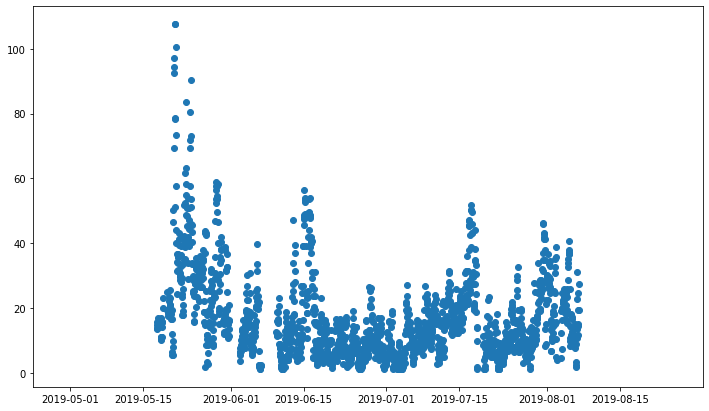

In [21]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df3mean['time'], df3mean['pm2.5'])

In [22]:
# Shift columns
df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-1)
df3mean[['time_shift-1']] = df3mean[['time']].shift(-1)

In [23]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time,pm2.5_shift-1,time_shift-1
0,5,17,17,4.0,17.458333,11.75,14.75,19.25,27.5,70.00,2019-05-17 16:54:00+08:00,15.50,2019-05-17 17:54:00+08:00
1,5,17,18,4.0,18.458333,11.25,15.50,15.50,28.0,68.00,2019-05-17 17:54:00+08:00,13.75,2019-05-17 18:54:00+08:00
2,5,17,19,4.0,19.458333,10.50,13.75,14.00,27.0,69.75,2019-05-17 18:54:00+08:00,13.50,2019-05-17 19:54:00+08:00
3,5,17,20,4.0,20.458333,10.50,13.50,13.75,27.0,69.00,2019-05-17 19:54:00+08:00,14.25,2019-05-17 20:54:00+08:00
4,5,17,21,4.0,21.458333,11.00,14.25,14.25,27.0,69.25,2019-05-17 20:54:00+08:00,15.00,2019-05-17 21:54:00+08:00


In [24]:
# check the next row is the next hour or not. 
# If it is not, the `pm2.5_next_hour` column will be given NaN.

def check_next_hour(x):
    one_hour = dt.timedelta(hours=1)
    if x[2] - x[1] == one_hour:
        return x[0]
    return np.nan

df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)

In [25]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time,pm2.5_shift-1,time_shift-1,pm2.5_next_hour
0,5,17,17,4.0,17.458333,11.75,14.75,19.25,27.5,70.00,2019-05-17 16:54:00+08:00,15.50,2019-05-17 17:54:00+08:00,15.50
1,5,17,18,4.0,18.458333,11.25,15.50,15.50,28.0,68.00,2019-05-17 17:54:00+08:00,13.75,2019-05-17 18:54:00+08:00,13.75
2,5,17,19,4.0,19.458333,10.50,13.75,14.00,27.0,69.75,2019-05-17 18:54:00+08:00,13.50,2019-05-17 19:54:00+08:00,13.50
3,5,17,20,4.0,20.458333,10.50,13.50,13.75,27.0,69.00,2019-05-17 19:54:00+08:00,14.25,2019-05-17 20:54:00+08:00,14.25
4,5,17,21,4.0,21.458333,11.00,14.25,14.25,27.0,69.25,2019-05-17 20:54:00+08:00,15.00,2019-05-17 21:54:00+08:00,15.00


In [26]:
df3mean.isna().sum()

month               0
day                 0
hour                0
weekday             0
hour_minute         0
pm1.0               0
pm2.5               0
pm10.0              0
temp                0
humidity            0
time                0
pm2.5_shift-1       1
time_shift-1        1
pm2.5_next_hour    10
dtype: int64

In [27]:
# Discard rows that contain NaN value
df3mean.dropna(inplace=True)

In [28]:
df3mean.isna().sum()

month              0
day                0
hour               0
weekday            0
hour_minute        0
pm1.0              0
pm2.5              0
pm10.0             0
temp               0
humidity           0
time               0
pm2.5_shift-1      0
time_shift-1       0
pm2.5_next_hour    0
dtype: int64

### Normalization

$z = \frac{x- \mu}{\sigma}$


In [29]:
# Save time infomation in another df, and discard it
df3mean_time_shift = df3mean['time_shift-1']
df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)
# Save mean and std
mean_all = df3mean.mean()
std_all = df3mean.std()
# Normalization
df3mean = (df3mean - df3mean.mean()) / df3mean.std()

### Divid training set and test set

In [30]:
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)

In [31]:
train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

In [32]:
train_df_time_shift = df3mean_time_shift[:four_fifth_len]
test_df_time_shift = df3mean_time_shift[four_fifth_len:]

In [33]:
X = train_df[['month', 'day', 'weekday', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
y = train_df[['pm2.5_next_hour']]

In [34]:
test_X = test_df[['month', 'day', 'weekday', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
test_y = test_df[['pm2.5_next_hour']]

### Fit the model

using `sklearn.linear_model.LinearRegression`

In [35]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [36]:
# See the coefficients of our model
a = model.coef_
b = model.intercept_
print(a)
print(b)

[[-0.02179605 -0.00310505 -0.00086821  0.0274275   0.14008678  0.60837447
   0.17428155 -0.08646224 -0.05591899]]
[-0.00901682]


In [37]:
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))

Coefficient for      month:	-0.021796045453230793
Coefficient for        day:	-0.0031050548381930513
Coefficient for    weekday:	-0.0008682072912132136
Coefficient for hour_minute:	0.027427504010033455
Coefficient for      pm1.0:	0.1400867810908017
Coefficient for      pm2.5:	0.6083744679229453
Coefficient for     pm10.0:	0.174281552616937
Coefficient for       temp:	-0.08646224262362522
Coefficient for   humidity:	-0.055918986234047056


In [38]:
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Calculate mean squared error for training set & test set
train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.1391297950093409
Test MSE:	 0.10885955188158712


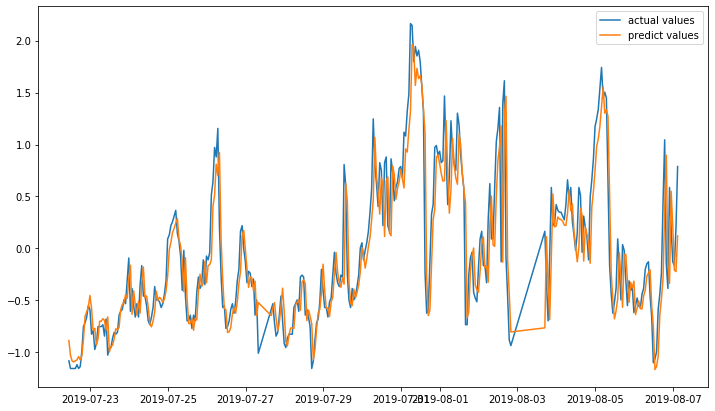

In [39]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time_shift, test_y, label='actual values')
plt.plot(test_df_time_shift, predict_y, label='predict values')
plt.legend()
plt.show()

### Feature Selection via Ridge Regression

~~Our test error is worse than our training error. Therefore, our next job is to improve this.~~

Next, we improve mean squared error. 

We use the class `sklearn.linear_model.Ridge`. We will throw all features in, let ridge regression do selection, and see how our own feature sets compare. Notice we have an additional hyperparameter,  𝛼 . This controls how heavy the penalty is for larger weights.

To perform hyperparameter tuning we can use a technique called **cross validation**. We take our test set, randomly divide into  𝑘  training and testing sets. Differnent samples will be randomly placed in each set, each with their own variance. We then average the results over the folds to estimate how well we will do on unseen test data. After splitting the data into  𝑘  folds (10 is a usual choice for  𝑘 ), we will try out different hyperparameter values and select the best one. Much of this process is already wrapped in `sklearn.model_selection.cross_val_score` for us. We just need to define a scoring function.


In [40]:
# Define a scoring function
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [41]:
# Define a range of values for alpha to search over.
alphas = np.linspace(start=0, stop=0.03, num=11)

mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, X, y, cv=10, scoring=scorer)
    mses.append(mse.mean())

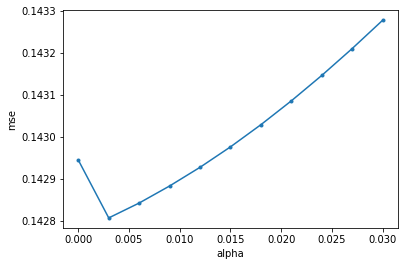

In [42]:
plt.plot(alphas, mses, marker='.')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [43]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.003

In [44]:
# Use `best_alpha` to fit the model
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(X, y)

Ridge(alpha=0.003, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [45]:
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], ridge.coef_[0][i]))

Coefficient for      month:	-0.02416743903285133
Coefficient for        day:	-0.0037820316165714687
Coefficient for    weekday:	-0.0008849417344408951
Coefficient for hour_minute:	0.026379913326290912
Coefficient for      pm1.0:	0.22241093411497445
Coefficient for      pm2.5:	0.4132732212723141
Coefficient for     pm10.0:	0.2875600730308049
Coefficient for       temp:	-0.08594657509062457
Coefficient for   humidity:	-0.05340561884736104


In [46]:
# Calculate mean squared error for training set & test set
predict_train_y = ridge.predict(X)
predict_y = ridge.predict(test_X)
# Calculate mean squared error for training set & test set
train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.1392303965728396
Test MSE:	 0.10874346887295108


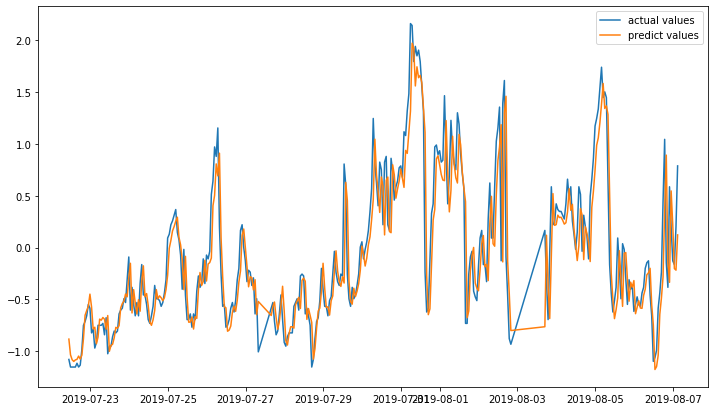

In [47]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time_shift, test_y, label='actual values')
plt.plot(test_df_time_shift, predict_y, label='predict values')
plt.legend()
plt.show()

### Feature Selection by myself

In [48]:
# Select features I want
X_fsm = X[['pm2.5', 'temp', 'humidity']]
test_X_fsm = test_X[['pm2.5', 'temp', 'humidity']]

In [49]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X_fsm, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [50]:
# See the coefficients of our model
for i in range(len(X_fsm.columns)):
    print('Coefficient for %10s:\t%s' % (X_fsm.columns[i], model.coef_[0][i]))

Coefficient for      pm2.5:	0.9205069169959699
Coefficient for       temp:	-0.0898723872822497
Coefficient for   humidity:	-0.07145815558017676


In [51]:
# Calculate predict value
predict_train_y = model.predict(X_fsm)
predict_y = model.predict(test_X_fsm)
# Calculate mean squared error for training set & test set
train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.1403784273092446
Test MSE:	 0.10610706088494778


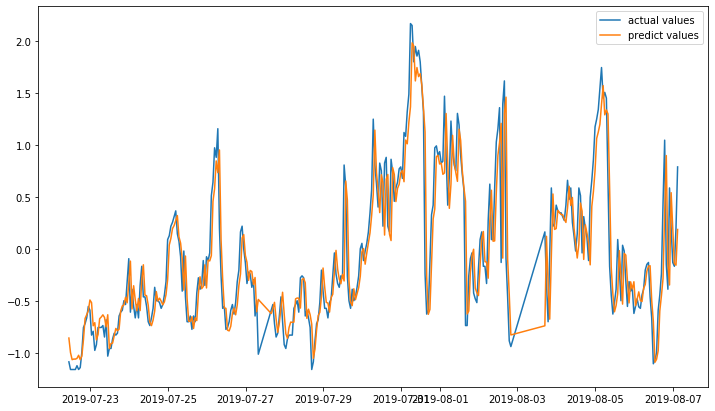

In [52]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time_shift, test_y, label='actual values')
plt.plot(test_df_time_shift, predict_y, label='predict values')
plt.legend()
plt.show()

In [53]:
# Transform normalized data back to original data
m = mean_all['pm2.5_next_hour']
s = std_all['pm2.5_next_hour']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

In [54]:
# Calculate mean squared error for training set & test set
train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %s,\t sqrt: %s (μg/m^3)' % (train_mse, np.sqrt(train_mse)))
print('Test MSE:\t %s,\t sqrt: %s (μg/m^3)' % (test_mse, np.sqrt(test_mse)))

Train MSE:	 26.101508129232098,	 sqrt: 5.1089635083089115 (μg/m^3)
Test MSE:	 19.729201739496908,	 sqrt: 4.441756605161623 (μg/m^3)


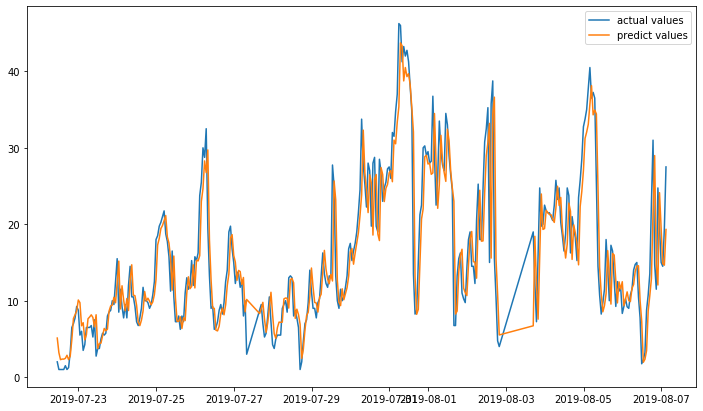

In [55]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time_shift, test_y_ori, label='actual values')
plt.plot(test_df_time_shift, predict_y_ori, label='predict values')
plt.legend()
plt.show()

### Predict next hour

將所有步驟寫成一個 function 。


In [56]:
def predict(pos):    
    # Load data
    data3 = get_data_by_pos(pos)
    df3 = pd.DataFrame(data3)
    # Input time
    time = ['2019 05 11', '2019 08 06']
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    # df3 = df3.loc[ df3['date'] >= start_time ]
    # df3 = df3.loc[ df3['date'] <= end_time ]
    if pos == 2:
        # Input time
        time = ['2019 06 06', '2019 08 06']
        taipei_tz = pytz.timezone('Asia/Taipei')
        # Set time
        start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
        end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
        # Select the duration
        df3 = df3.loc[ df3['date'] >= start_time ]
        # df3 = df3.loc[ df3['date'] <= end_time ]
    # Rename the names of columns
    df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
    # Exclude outliers
    # want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
    # df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 4).all(axis=1)]
    df3 = df3.loc[ df3['pm2.5'] < 120 ]
    # Split time infomation from column `date`
    df3['month'] = df3['date'].apply(lambda x: x.month)
    df3['day'] = df3['date'].apply(lambda x: x.day)
    df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
    df3['hour'] = df3['date'].apply(lambda x: x.hour)
    df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
    # Set the order of the columns & discard some columns
    df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    # Evaluate mean values for each hour
    df3mean = df3.groupby(['month', 'day', 'hour']).mean()
    df3mean.reset_index(inplace=True)
    # Reconstruct time infomation by `month`, `day`, and `hour`
    df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)
    # Shift columns
    df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-1)
    df3mean[['time_shift-1']] = df3mean[['time']].shift(-1)
    # Check the next row is the next hour or not. 
    # If it is not, the `pm2.5_next_hour` column will be given NaN.
    
    def check_next_hour(x):
        n_hour = dt.timedelta(hours=1)
        if x[2] - x[1] == n_hour:
            return x[0]
        return np.nan
    
    df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)
    # Discard rows that contain NaN value
    df3mean.dropna(inplace=True)
    # Save time infomation in another df, and discard it
    df3mean_time_shift = df3mean['time_shift-1']
    df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)
    # Normalization
    df3mean = (df3mean - df3mean.mean()) / df3mean.std()
    # Divid training set and test set
    four_fifth_len = len(df3mean)*0.8
    four_fifth_len = int(four_fifth_len)

    train_df = df3mean[:four_fifth_len]
    test_df = df3mean[four_fifth_len:]

    train_df_time_shift = df3mean_time_shift[:four_fifth_len]
    test_df_time_shift = df3mean_time_shift[four_fifth_len:]

    X = train_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    y = train_df[['pm2.5_next_hour']]

    test_X = test_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    test_y = test_df[['pm2.5_next_hour']]
    # Select features I want
    X_fsm = X[['pm2.5', 'temp', 'humidity']]
    test_X_fsm = test_X[['pm2.5', 'temp', 'humidity']]
    # Fit the model
    model = linear_model.LinearRegression(normalize=True)
    model.fit(X_fsm, y)
    # See the coefficients of our model
    for i in range(len(X_fsm.columns)):
        print('Coefficient for %10s:\t%s' % (X_fsm.columns[i], model.coef_[0][i]))
    # Calculate predict value
    predict_train_y = model.predict(X_fsm)
    predict_y = model.predict(test_X_fsm)
    # Transform normalized data back to original data
    m = mean_all['pm2.5_next_hour']
    s = std_all['pm2.5_next_hour']

    test_y_ori = test_y * s + m
    predict_y_ori = predict_y * s + m

    y_ori = y * s + m
    predict_train_y_ori = predict_train_y * s + m
    
    # Calculate mean squared error for training set & test set
    train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
    test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

    print('Train MSE:\t %s,\t sqrt: %s (μg/m^3)' % (train_mse, np.sqrt(train_mse)))
    print('Test MSE:\t %s,\t sqrt: %s (μg/m^3)' % (test_mse, np.sqrt(test_mse)))
    # Add explicitly converter
    pd.plotting.register_matplotlib_converters()
    # Plt
    plt.figure(figsize=(12, 7))
    plt.style.use('ggplot')
    plt.plot(test_df_time_shift, test_y_ori, label='actual value')
    plt.plot(test_df_time_shift, predict_y_ori, label='predict value')
    plt.xticks(rotation=45)
    plt.ylabel('(μg/m^3)')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title('Testing set')
    plt.show()

Coefficient for      pm2.5:	0.9124663081070442
Coefficient for       temp:	-0.13926014919701987
Coefficient for   humidity:	-0.12177502898187113
Train MSE:	 24.519724253656243,	 sqrt: 4.951739517952882 (μg/m^3)
Test MSE:	 19.691565096984952,	 sqrt: 4.43751789821573 (μg/m^3)


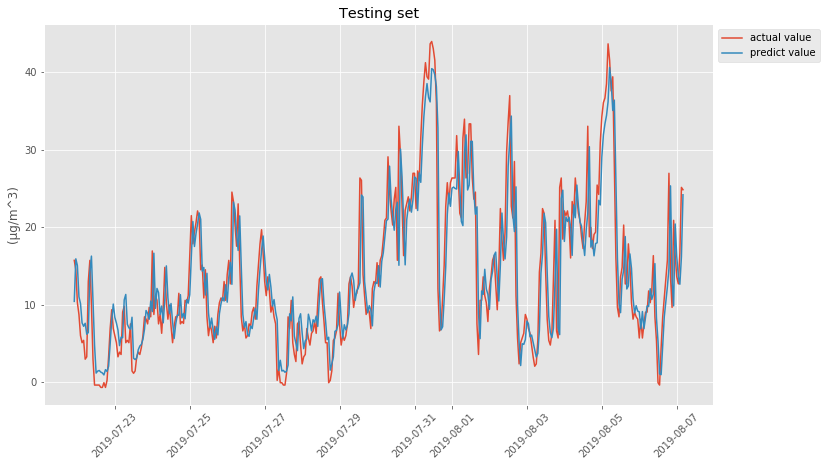

In [57]:
predict(3)

記錄各個位置的 MSE (8/6)

| Position  | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
| --------- | - | - | - | - | - | - | - | - |
| Train MSE | 0.1399 | 0.1241 | 0.2029 | 0.1320 | 0.1878 | 0.1172 | 0.0948 | 0.1120 |
| Test MSE  | 0.0985 | 0.1841 | 0.1985 | 0.0985 | 0.2044 | 0.1015 | 0.1919 | 0.1002 |


### Predict next `N` hour 

嘗試用一樣的方法預測下`N`個小時的pm2.5平均。


In [58]:
def predict_next_n(pos, n):    
    # Load data
    data3 = get_data_by_pos(pos)
    df3 = pd.DataFrame(data3)
    # Input time
    time = ['2019 05 11', '2019 08 06']
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    # df3 = df3.loc[ df3['date'] >= start_time ]
    # df3 = df3.loc[ df3['date'] <= end_time ]
    if pos == 2:
        # Input time
        time = ['2019 06 06', '2019 08 06']
        taipei_tz = pytz.timezone('Asia/Taipei')
        # Set time
        start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
        end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
        # Select the duration
        df3 = df3.loc[ df3['date'] >= start_time ]
        # df3 = df3.loc[ df3['date'] <= end_time ]
    # Rename the names of columns
    df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
    # Exclude outliers
    # want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
    # df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 4).all(axis=1)]
    df3 = df3.loc[ df3['pm2.5'] < 120 ]
    # Split time infomation from column `date`
    df3['month'] = df3['date'].apply(lambda x: x.month)
    df3['day'] = df3['date'].apply(lambda x: x.day)
    df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
    df3['hour'] = df3['date'].apply(lambda x: x.hour)
    df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
    # Set the order of the columns & discard some columns
    df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    # Evaluate mean values for each hour
    df3mean = df3.groupby(['month', 'day', 'hour']).mean()
    df3mean.reset_index(inplace=True)
    # Reconstruct time infomation by `month`, `day`, and `hour`
    df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)
    # Shift columns
    df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-n)
    df3mean[['time_shift-1']] = df3mean[['time']].shift(-n)
    # Check the next row is the next hour or not. 
    # If it is not, the `pm2.5_next_hour` column will be given NaN.
    
    def check_next_hour(x):
        n_hour = dt.timedelta(hours=n)
        if x[2] - x[1] == n_hour:
            return x[0]
        return np.nan
    
    df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)
    # Discard rows that contain NaN value
    df3mean.dropna(inplace=True)
    # Save time infomation in another df, and discard it
    df3mean_time_shift = df3mean['time_shift-1']
    df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)
    # Normalization
    df3mean = (df3mean - df3mean.mean()) / df3mean.std()
    # Divid training set and test set
    four_fifth_len = len(df3mean)*0.8
    four_fifth_len = int(four_fifth_len)

    train_df = df3mean[:four_fifth_len]
    test_df = df3mean[four_fifth_len:]

    train_df_time_shift = df3mean_time_shift[:four_fifth_len]
    test_df_time_shift = df3mean_time_shift[four_fifth_len:]

    X = train_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    y = train_df[['pm2.5_next_hour']]

    test_X = test_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    test_y = test_df[['pm2.5_next_hour']]
    # Select features I want
    X_fsm = X[['pm2.5', 'temp', 'humidity']]
    test_X_fsm = test_X[['pm2.5', 'temp', 'humidity']]
    # Fit the model
    model = linear_model.LinearRegression(normalize=True)
    model.fit(X_fsm, y)
    # See the coefficients of our model
    for i in range(len(X_fsm.columns)):
        print('Coefficient for %10s:\t%s' % (X_fsm.columns[i], model.coef_[0][i]))
    # Calculate predict value
    predict_train_y = model.predict(X_fsm)
    predict_y = model.predict(test_X_fsm)
    # Transform normalized data back to original data
    m = mean_all['pm2.5_next_hour']
    s = std_all['pm2.5_next_hour']

    test_y_ori = test_y * s + m
    predict_y_ori = predict_y * s + m

    y_ori = y * s + m
    predict_train_y_ori = predict_train_y * s + m
    
    # Calculate mean squared error for training set & test set
    train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
    test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

    print('Train MSE:\t %s,\t sqrt: %s (μg/m^3)' % (train_mse, np.sqrt(train_mse)))
    print('Test MSE:\t %s,\t sqrt: %s (μg/m^3)' % (test_mse, np.sqrt(test_mse)))
    # Add explicitly converter
    pd.plotting.register_matplotlib_converters()
    # Plt
    plt.figure(figsize=(12, 7))
    plt.style.use('ggplot')
    plt.plot(test_df_time_shift, test_y_ori, label='actual value')
    plt.plot(test_df_time_shift, predict_y_ori, label='predict value')
    plt.xticks(rotation=45)
    plt.ylabel('(μg/m^3)')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title('Testing set')
    plt.show()

Coefficient for      pm2.5:	0.796827096227923
Coefficient for       temp:	-0.20455615765936366
Coefficient for   humidity:	-0.20614636642062978
Train MSE:	 62.63054325286642,	 sqrt: 7.913946123955256 (μg/m^3)
Test MSE:	 49.04672882989566,	 sqrt: 7.003336978176594 (μg/m^3)


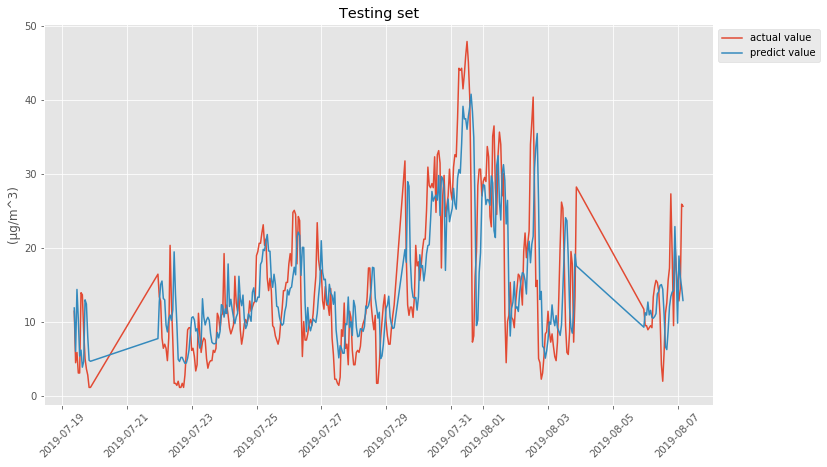

In [59]:
predict_next_n(pos=7, n=3)

## 不區分 Position 的 Linear Regression

未完成...

### Load data


In [60]:
data = get_all_data()

In [61]:
df = pd.DataFrame(data)

### Data preprocessing

In [62]:
# rename the names of columns
df = df.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

In [63]:
df.head()

,_cls,date,humidity,pm1.0,pm10.0,pm2.5,position,temp
0,models.data_model.PMData,2019-05-11 09:28:17+08:00,62,50,94,78,3,28
1,models.data_model.PMData,2019-05-11 09:29:44+08:00,67,42,81,72,5,27
2,models.data_model.PMData,2019-05-11 09:43:14+08:00,61,36,71,60,3,29
3,models.data_model.PMData,2019-05-11 09:44:42+08:00,67,41,82,70,5,27
4,models.data_model.PMData,2019-05-11 09:58:13+08:00,59,39,75,63,3,29


In [64]:
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['weekday'] = df['date'].apply(lambda x: x.weekday)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['hour_minute'] = df['date'].apply(lambda x: x.hour+x.minute/60)

In [65]:
df.head()

,_cls,date,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute
0,models.data_model.PMData,2019-05-11 09:28:17+08:00,62,50,94,78,3,28,5,11,5,9,9.466667
1,models.data_model.PMData,2019-05-11 09:29:44+08:00,67,42,81,72,5,27,5,11,5,9,9.483333
2,models.data_model.PMData,2019-05-11 09:43:14+08:00,61,36,71,60,3,29,5,11,5,9,9.716667
3,models.data_model.PMData,2019-05-11 09:44:42+08:00,67,41,82,70,5,27,5,11,5,9,9.733333
4,models.data_model.PMData,2019-05-11 09:58:13+08:00,59,39,75,63,3,29,5,11,5,9,9.966667


In [66]:
df.drop(columns=['_cls', 'date'], inplace=True)
df.head()

,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute
0,62,50,94,78,3,28,5,11,5,9,9.466667
1,67,42,81,72,5,27,5,11,5,9,9.483333
2,61,36,71,60,3,29,5,11,5,9,9.716667
3,67,41,82,70,5,27,5,11,5,9,9.733333
4,59,39,75,63,3,29,5,11,5,9,9.966667


In [67]:
df[['pm2.5_next']] = df[['pm2.5']].shift(-1)

In [68]:
df.dropna(inplace=True)
df.tail()

,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute,pm2.5_next
50954,75,14,28,26,5,26,8,7,2,4,4.033333,20.0
50955,73,12,21,20,6,26,8,7,2,4,4.033333,15.0
50956,79,9,18,15,4,26,8,7,2,4,4.050000,23.0
50957,72,16,24,23,7,27,8,7,2,4,4.100000,19.0
50958,72,12,22,19,2,26,8,7,2,4,4.116667,22.0


In [69]:
four_fifth_len = len(df)*0.8
four_fifth_len = int(four_fifth_len)

In [70]:
train_df = df[:four_fifth_len]
test_df = df[four_fifth_len:]

In [71]:
X = train_df[['month', 'day', 'hour', 'pm1.0', 'pm10.0', 'pm2.5', 'temp', 'humidity', 'position']]
y = train_df[['pm2.5_next']]

In [72]:
test_X = test_df[['month', 'day', 'hour', 'pm1.0', 'pm10.0', 'pm2.5', 'temp', 'humidity', 'position']]
test_y = test_df[['pm2.5_next']]